# Final Report for PH4419
## Brian Chia, U1740136B
### A short insight into the behaviour of ferromagnetic materials.

## Abstract

In this report, we explore the implementation of a 2D Ising model using the Metropolis algorithm in Python.
The Ising model is of particular interest because it demonstrates a second-order phase transition depsite its relative simplicity.

To study the behaviour of ferromagnetic materials, several parameters were measured and figures of the lattice was created. The simulations demonstrated a clear phase transition near critical temperature with measured parameters corresponding well to the exact solution of the Ising model.

## Introduction
Ferromagnets are a class of materials that retain their magnetization in the absence of an external magnetic field. They exhibit long-range ordering at the atomic level causing the formation of domains (areas where unpaired electrons have aligned spins). Within each domain, the magnetic field is intense. In unmagnetized domains, opposite spins cancel each other's magnetic field, but in the presence of an external magnetic field, a nonzero net magnetization can occur.

The long-range ordering phenomenon disappears at a certain temperature (called the Curie temperature [named after Pierre Curie, not Marie Curie.]). At this critical temperature, the system can no longer sustain spontaneous magnetization and a second-order phase transition happens. The 2-dimensional Ising model is the simplest model that describes ferromagnetism and second-order phase transitions.

### Ising Model
The Ising model is a square lattice, each element contains a value of "+1" for spin up, and "-1" for spin down. Each spin will only interact with its immediate neighbours. We set the boundary conditions up as a torus where spins on opposite geometric edges are considered as neighbours. The exact solution to the 2-dimensional Ising model without the presence of an external magnetic field has been solved by Lars Onsagers.

Onsagers [2] showed that the model undergoes a phase transition at the critical temperature
\begin{equation}
    T_C = \frac{2}{k_B \log (\sqrt{2} + 1)} \approx 2.27.
\end{equation}

The spontaneous magnetization that occurs at temperatures below $T_C$ is
\begin{equation}
    M = \left( 1 - \sinh^{-4} \frac{2J}{k_B T} \right)^{\frac{1}{8}}.
\end{equation}

To simplify the model, we will use natural units and set constants (such as $k_B$, $\mu$, $J$, etc.) to 1.

## Methodology
### Cython
Cython is a Python module that allows us to easily create Python extensions. Cython itself is a superset of Python that supports the calling of C functions and declaration of C types of variables and class attributes. Cython enables users with little knowledge of the C programming language to gain C like performance by just adding static type declarations. In this project, we use Cython extensively to optimize the performance of our code. This results in a 4 times speedup over the pure Python version. While there are many ways of furthering increasing performance, we chose not to do so in order to make the code more readable for people not familar with the C language.

### Metropolis algorithm
The Ising model will take a long time to solve numerically since the number of possible states for a $N$ by $N$ square lattice is $2^N$. The Ising model is often simulated using the Monte Carlo method and the algorithm used most often is the Metropolis-Hastings algorithm. The Metropolis algorithm is used to determine if a spin flips. The steps of the Metropolis algorithm are as follow:
<ol>
    <li> Randomly select a spin site on the lattice. </li>
    <li> Compute the change in energy $dE$ when the spin is flipped. </li>
    <li> If $dE \leq 0$, the spin is flipped with probability 1. </li>
    <li> If $dE > 0$, the spin is flipped with the probability $\exp{\frac{-dE}{k_B T}}$. </li>
</ol>

### Wolff algorithm [1]
One of the limitations of the Metropolis algorithm is the occurece of "critical slowing down" near the critical temperature. This is due to the size of correlated regions of spin becoming larger as we approach the critical temperature. Hence, the time required for a region to lose its coherence becomes very long. Instead of performing a single spin (as in the Metropolis algorithm), the Wolff algorithm flips a cluster of spins. This is an example of a global algorithm. 

We introduce a bond between any 2 neighbouring spins, the probability for such. bond to exisit is $p$. The bond probability depends on the temperature and is given by:
\begin{equation}
    p = 1 - \exp{-\frac{2J}{k_B T}}.
\end{equation}
We would first generate a cluster of neighbouring spins with this bond probability and then flip the cluster with probability 1. The steps of Wolff algorithm are as follow:
<ol>
    <li> Select a random spin site on the lattice. The neighbouring spins are known as the "neighbours". </li>
    <li> Select a neighbouring spin and generate a random number $r$, if $r \leq p$, a bond exists between the two spins and the neighbouring spin is added to the cluster. That spin site will no longer be checked. </li>
    <li> If a spin is added to the cluster, its neighbouring spins will now be added into "neighbours". </li>
    <li> Repeat step 2 and 3 until no neighbouring spins remain. </li>
    <li> Flip every spin in the cluster. </li>
</ol>


### Thermodynamic quantities
The followwing thermodynamic quantities were measured:
<ol>
    <li> $e(i,j)$ - The energy $e$ at one specific site $(i,j)$ on a lattice $S$ (we assume there an absence of an external magnetic field) is given by:
        \begin{equation}
        e(i,j) = -S(i,j) \cdot [S(i+1,j) + S(i-i,j) + S(i,j+1) + S(i,j-1)].
        \end{equation} </li>
    <li> $E$ - The total energy $E$ is given by:
        \begin{equation}
        E = \sum_{i,j} e(i,j).
        \end{equation} </li>
    <li> $dE$ - The change in energy $dE$ for flipping one spin site is given by:
        \begin{equation}
        dE = -2 e(i,j) = 2 S(i,j) \cdot [S(i+1,j) + S(i-i,j) + S(i,j+1) + S(i,j-1)].
        \end{equation}
        Hence the maximum energy change per flip is $\pm 8$. </li>
    <li> $M$ - The total magnetization $M$ of the lattice is given by:
        \begin{equation}
        M = \sum_{i,j} S(i,j).
        \end{equation} </li>
    <li> $C_V$ - The specific heat $C_v$ of the lattice is given by:
        \begin{equation}
            C_v = \frac{1}{N^2} \frac{1}{T^2} \left[\langle E^2 \rangle - \langle E \rangle ^2 \right]
        \end{equation} </li>
    <li> $\chi$ - The magnetic susceptibility $\chi$ of the lattice is given by:
        \begin{equation}
        \chi = \frac{1}{N^2} \frac{1}{T} \left[\langle M^2 \rangle - \langle M \rangle ^2 \right]
        \end{equation} </li>
</ol>
The prefactor $\frac{1}{N^2}$ used for $C_V$ and $\chi$ is there to normalize our results [3].

## Implementation
An object oriented approach was taken with methods and attributes held in the the relevant classes. A class called "cy_Lattice" contains all the methods and attributes (such as size of lattice, temperature, total energy, total magnetization, etc. ) related to the simulation of the Ising model. A class called "cy_Figures" contains the methods used to generate plots of the simulation.

We start from a ground state (where all initial spins are aligned), and raise the temperature. At every temperature step, we measure and calculate each quantity. We then plot each quantity with respect to temperature, we also plot the evolution of the lattice at various temperatures.

## Results
The plots of thermodynamic quantities was simulated on a 12 by 12 lattice, and  on a 36 by 36 lattice. The model was left to equilibrate for 50000 steps. The lattice evolution plots were simulated on a 128 by 128 lattice.

The peak of the specific heat capactiy and magnetic susceptibility reveal that the system underwent a phase transition at the critical temperature of $T_C \approx 2.27$. The peak was more accurately simulated on the smaller lattice. Using a larger lattice resulted in a wider peak, increasing the error of the measured critical temperature. 

Above the critical temperature the system becomes paramagnetic. Thermal fluctuations causes the random flipping of spins. At high temperatures, the number of flips increases and inhibits the formation of domains. When the temperature gets high enough, thermal exicitations will dominate the system.

At high temperatures ($T \gg T_C$), the system had a random lattice pattern with net zero magnetization and is in its highest energy state. Conversely, at low temperatures ($T \ll T_C$), there is minimal thermal excitations and the spins were more or less all aligned with each other in the lattice. The system was in the highest magnetization state and in the lowest energy state.

As seen in the plot for magnetization, the lattice becomes a paramagnet at the critical temperature. The magnetization rapidly decreases to 0 as temperature is raised. At low temepratures, the magnetic susceptibility of the system is low due to the low state of energy the system is in. Magnetic susceptibility is increased (due to the increase in system energy) as temperatures increase up until the critical temperatuure. The magnetic susceptibility peaks at $T_C$, and at higher temperatures, thermal fluctuations dominate and magnetic susceptibility tends to 0. We see the same peak for specific heat capacity.


## Further Improvments
There is still much room for model improvement. Some possibilities are listed below.

<ol>
    <li> Introduce an external magnetic field and study the effects of hysteresis. </li>
    <li> Optimize the implemented Wolff algorithm. </li>
    <li> Perform finite size scaling and perform the critical exponents of the Ising model. </li>
    <li> Find a way to allow the model to stabilize into a stable state. </li>
</ol>

## Conclusion
The implemented Ising model demonstrated the phase transition as well as the breaking of symmetry and the spontaneous magnetization below the critcal temperature, matching analytical results. The results for the critical temperature (for a 12 by 12 lattice) closely follows the theoretical value. We conclude that the deviation was caused by insufficient computing power as the model was not given enough time to reach a stable state. Because of this limitation, the size of the lattice and time steps had to kept relatively small. The numerical results were strongly affected by the lattice size and time steps. The analytical solution for critical temperature assumed an infinite lattice, which is impossible to model. As a result, we expect that larger lattices will have larger deviations from the theoretical result. The language of choice Python also severely limited the computational speed of the program. Cython was introduced as a means to introduce the advantages of using a compiled language such as C. In reality, this program should have been written in C or Fortan for maximum computational efficiency.

## References
[1] Clark University. (2015). Statistical and Thermal Physics (STP) Curriculum Development Project. Retrieved from http://stp.clarku.edu.

[2] Onsager, L. (1944). Crystal Statistics. I. A Two-Dimensional Model with an Order-Disorder Transition. Physical Review, 65(3-4), 117–149. doi: 10.1103/physrev.65.117.

[3] Sova, M. (2014). Simulation of the Ising model.

## Appendix: Source Code

The simplest way to install Cython is by using pip: pip install Cython

In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
%%time
%%cython
## import python modules
import numpy as np
import matplotlib.pyplot as plt

## load cython modules
cimport cython
cimport numpy as np

## import C libaries into python
from libc.math cimport exp 
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX

cdef class cy_Lattice:
    cdef int N
    cdef float M,E,T
    cdef np.int64_t[:,:] array
    cdef list M_list, E_list
    
    ## class attributes
    def __init__(self, int N, float T):
        self.N = N ## lattice size
        self.M = 0 ## total magnetization
        self.E = 0 ## total energy
        self.T = T ## temperature
        self.array = np.full((self.N,self.N), -1, dtype=int) ## ground state (all spins aligned)
        self.E_total() ## total energy  
        self.M_total() ## total magnetization
        self.E_list = [] ## list that holds energy values
        self.M_list = [] ## list that holds magnetization values

    ## calculate energy of a lattice site
    ## we assume boundary boundary conditions (torus like)
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef calculate_energy(self,int i,int j):
        cdef float e = self.array[(i+1)%self.N,j] + self.array[(i-1)%self.N,j] + self.array[i,(j+1)%self.N] + self.array[i,(j-1)%self.N]
        return(-1.0*self.array[i,j]*e)    
    
    ## total energy of lattice
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef E_total(self):
        cdef float e = 0
        cdef int i,j
        for i in range(self.N):
            for j in range(self.N):
                e += self.calculate_energy(i,j)
        self.E = e
    
    ## total magnetization of lattice
    cdef M_total(self):
        self.M = np.sum(self.array)
        
    ## metropolis algorithm
    ## code is not fully working
    cdef metropolis(self, int steps):
        cdef int n,i,j
        cdef float dE
        for n in range(steps):
            ## select a random lattice site
            i,j = np.random.randint(0,self.N),np.random.randint(0,self.N)
            dE = -2.0*self.calculate_energy(i,j)
            
            if dE <= 0:
                self.array[i,j] *= -1 ## flip spin
                self.E += dE
                self.M += 2*self.array[i,j]
                self.M_list.append(self.M)
                self.E_list.append(self.E)
                
            elif rand()/RAND_MAX < exp(-1.0*dE/self.T): ## probability to flip if dE > 0
                self.array[i,j] *= -1 ## flip spin
                self.E += dE
                self.M += 2*self.array[i,j]
                self.M_list.append(self.M)
                self.E_list.append(self.E)
    
    ## get neighbours around spin site
    def get_neighbours(self,i):
        return [((i-1)%self.N),((i+1)%self.N),((i-self.N)%self.N),((i+self.N)%self.N)]

    ## get cluster arund spin site
    def get_cluster(self, i, temp, cluster, visited):
        ## convert 2d array into 1d array
        config = np.ravel(self.array)
        ## get spin of random site
        spin = config[i]
        ## get neighbours of spin site
        neighbours = self.get_neighbours(i)
        ## append spin site into cluster and visited list
        cluster.append(i)
        visited.append(i)
        
        ## check against all neighbours
        for n in neighbours:
            ## if neighbour's spin and random spin site match
            if config[n] == spin:
                ## check that we did not visit the spin site before
                if n not in visited:
                    prob = 1 - np.exp(-2.0/(self.T))
                    ## append neighbour to cluster if it satisifies the probability
                    if np.random.rand() > prob:
                        cluster = self.get_cluster(n, self.T, cluster, visited)
        return cluster

    ## run the wolff algorithm
    def wolff(self,steps):
        ## convert 2d array into 1d array
        config = np.ravel(self.array)
        
        ## flip whole cluster
        def flip_cluster(self, cluster):
            for i in cluster:
                ## flip spin (+/- 1 to -/+ 1)
                config[i] *= -1
        
        for n in range(steps):
            ## select a random lattice site
            i = np.random.randint(0,self.N)
            ## get cluster based on spin site
            cluster = self.get_cluster(i, self.T, [], [])
            ## flip everything in the cluster
            flip_cluster(self, cluster)
        
        ## convert 1d array back to 2d array
        array = np.array(config)
        self.array = array.reshape((self.N, self.N))


            
cdef class cy_Figures:
    cdef cy_Lattice lattice
    cdef int N, steps
    cdef float t_start, t_end, dt
    cdef str title, xlabel, ylabel, c
    cdef list data
    cdef np.int64_t[:,:] array
    
    ## class atributes
    def __init__(self,int N=16,float t_start=1.0,float t_end=5.0,float dt=0.1,int steps=50000):
        self.N = N
        self.dt = dt
        self.t_start = t_start
        self.t_end = t_end
        self.dt = dt
        self.steps = steps
        self.title = '$N={}$, $T_i={}$, $T_f={}$, $dT={:.2f}$, Steps = {}'.format(self.N,self.t_start,self.t_end,self.dt,self.steps)
    
    ## normalize array to proper values
    cdef normalize_array(self, list array):
        cdef float i
        return [1.0*i/(self.N**2) for i in array]
    
    ## calculate specific heat
    cdef calculate_cv(self, list E_list, float T):
        ## avgE = <E>, avgE2 = <E>^2
        cdef float avgE = np.average(E_list)
        cdef float avgE2 = avgE*avgE
        ## avg_E2 = <E^2>
        cdef float avg_E2 = sum([i*i  for i in E_list])/len(E_list)
        cdef float C = (1.0/(self.N*self.N)) * (1.0/T**2) * (avg_E2-avgE2)
        return C
    
    ## calculate magnetic susceptibility
    cdef calculate_mag_sus(self, list M_list, float T):
        cdef float avgM = np.average(M_list)
        cdef float avgM2 = avgM*avgM
        cdef float avg_M2 = sum([i*i for i in M_list])/len(M_list)
        cdef float X = (1.0/(self.N*self.N)) * (1.0/T) * (avg_M2-avgM2)
        return X
    
    ## calculate energy wrt temperature
    cpdef energy(self):
        cdef float T
        cdef list T_list = []
        for T in np.arange(self.t_start,self.t_end,self.dt):
            lattice = cy_Lattice(self.N, T)
            lattice.metropolis(self.steps)
            T_list.append(np.average(lattice.E_list))
        self.data = cy_Figures.normalize_array(self, T_list)
        self.xlabel = 'Temperature (T)'
        self.ylabel = 'Energy (E)'
        self.c = 'red'
        cy_Figures.plot(self)
    
    ## calculate specific heat wrt to temperature
    cpdef specific_heat(self):
        cdef float T
        cdef list T_list = []
        for T in np.arange(self.t_start,self.t_end,self.dt):
            lattice = cy_Lattice(self.N, T)
            lattice.metropolis(self.steps)
            T_list.append(cy_Figures.calculate_cv(self, lattice.E_list, T))
        self.data = cy_Figures.normalize_array(self,T_list)
        self.xlabel = 'Temperature (T)'
        self.ylabel = 'Specific Heat $C_V$'
        self.c = 'red'
        cy_Figures.plot(self)
    
    ## calculate magnetization wrt to temperature
    cpdef mag(self):
        cdef float T
        cdef list T_list = []
        for T in np.arange(self.t_start,self.t_end,self.dt):
            lattice = cy_Lattice(self.N, T)
            lattice.metropolis(self.steps)
            T_list.append(np.abs(np.average(lattice.M_list)))
        self.data = cy_Figures.normalize_array(self,T_list)
        self.xlabel = 'Temperature (T)'
        self.ylabel = 'Magnetization (M)'
        self.c = 'blue'
        cy_Figures.plot_mag(self)

    ## calculate magnetic susceptibility wrt temperature
    cpdef mag_sus(self):
        cdef float T
        cdef list T_list = []
        for T in np.arange(self.t_start,self.t_end,self.dt):
            lattice = cy_Lattice(self.N, T)
            lattice.metropolis(self.steps)
            T_list.append(cy_Figures.calculate_mag_sus(self, lattice.M_list, T))
        self.data = cy_Figures.normalize_array(self,T_list)
        self.xlabel = 'Temperature (T)'
        self.ylabel = 'Magnetic susceptibility $\chi$'
        self.c = 'blue'
        cy_Figures.plot(self)
    
    
    ## plot lattice at different temperatures
    def plot_lattice(self):
        cdef list to_plot = []
        cdef int i,j,n = 0
        cdef float T
        cdef list temp = [1.0, 1.5, 2.0, 2.2, 2.27, 2.5, 3.0, 4.0, 5.0]

        for T in temp:
            lattice = cy_Lattice(self.N, T)
            lattice.metropolis(self.steps)
            self.array = lattice.array
            to_plot.append(self.array)
        
        fig, ax = plt.subplots(3,3,figsize=(15,15))
        fig.suptitle('N = {}'.format(self.N), x=0.5, y=0.93, fontsize=16)
        for i in range(3):
            for j in range(3):
                ax[i,j].imshow(to_plot[n])
                ax[i,j].axis('off')
                ax[i,j].set_title('T = {}'.format(temp[n]))
                n += 1
    
    ## plot observables wrt temperature
    cpdef plot(self):
        fig,ax = plt.subplots(figsize=(12,8))
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.title(self.title)
        ax.scatter(np.arange(self.t_start,self.t_end,self.dt), self.data, c=self.c)
        ## scale y axis
        dy = (max(self.data) - min(self.data))*0.1
        ax.set_ylim(min(self.data)-dy, max(self.data)+dy)
        plt.axvline(x=2.27,ls='--')
        plt.show()
        
    ## plot analytical solution on mag plot
    cpdef plot_mag(self):
        fig,ax = plt.subplots(figsize=(12,8))
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.title(self.title)
        ax.scatter(np.arange(self.t_start,self.t_end,self.dt), self.data, c=self.c)
        ## plot analytical solution
        x_axis = np.arange(1,2.27,0.01)
        y_axis = (1.0 - np.sinh(2/x_axis)**(-4))**(1/8)
        ax.plot(x_axis,y_axis,c='black',lw=2.0,label='Analytical solution for $T < T_C$')
        plt.axvline(x=2.27,ls='--')
        plt.legend()
        plt.show()
        

CPU times: user 1.13 s, sys: 56 ms, total: 1.19 s
Wall time: 10.3 s


## Lattice Evolution at $N=128$.

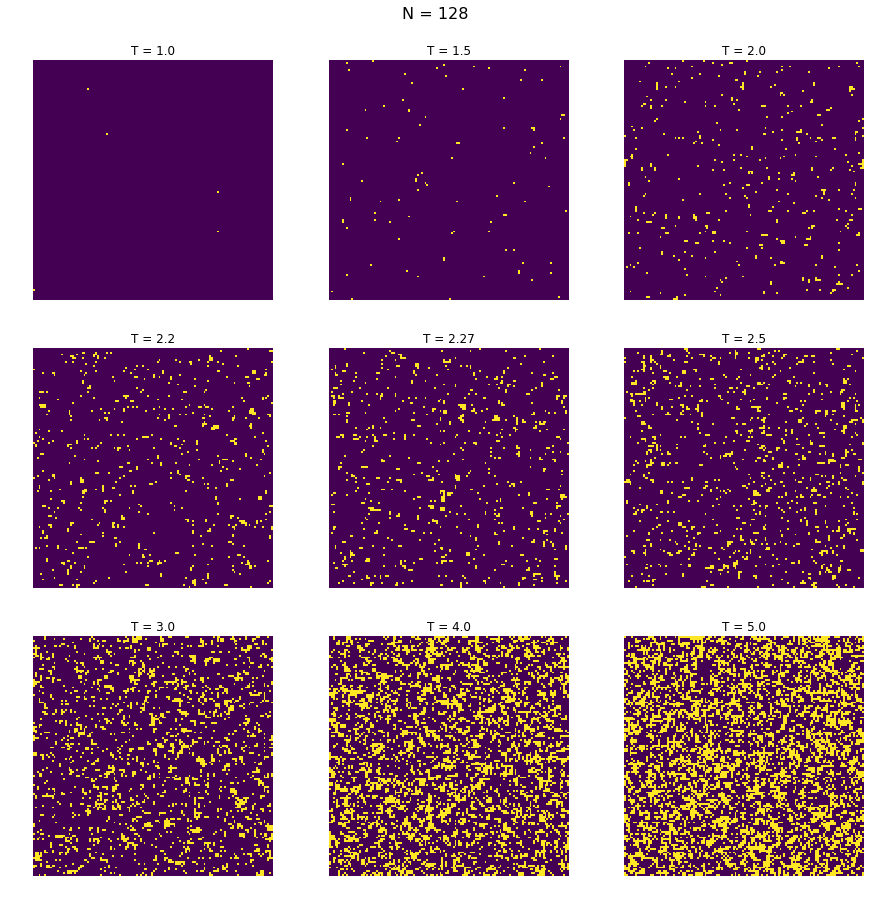

In [3]:
## N can be high valued here (only for plotting lattice)
cyP = cy_Figures(N=128,dt=0.01)
cyP.plot_lattice()

## Thermodynamic Quantities at $N=36$.

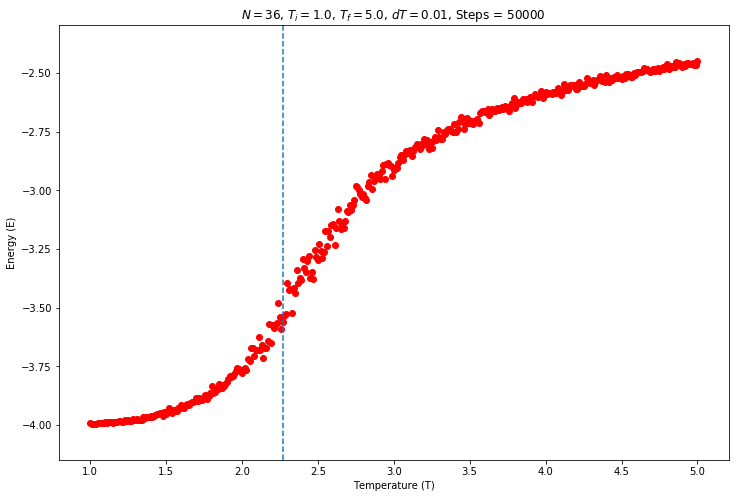

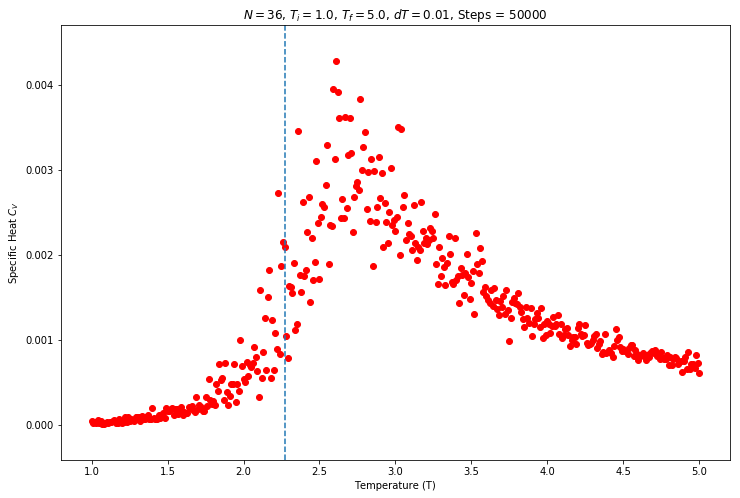

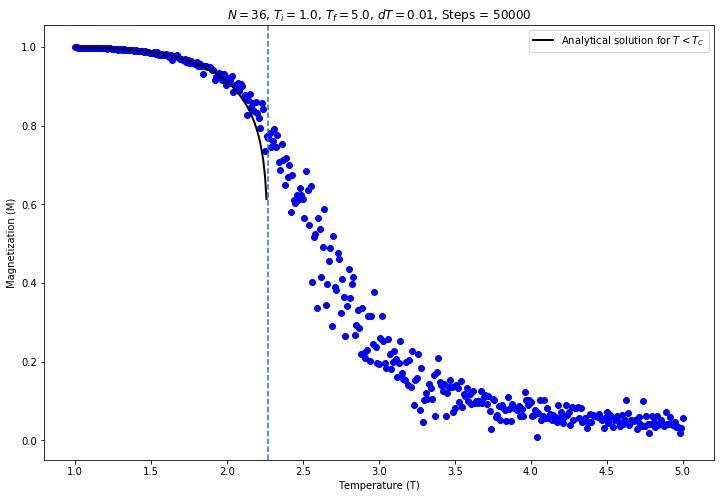

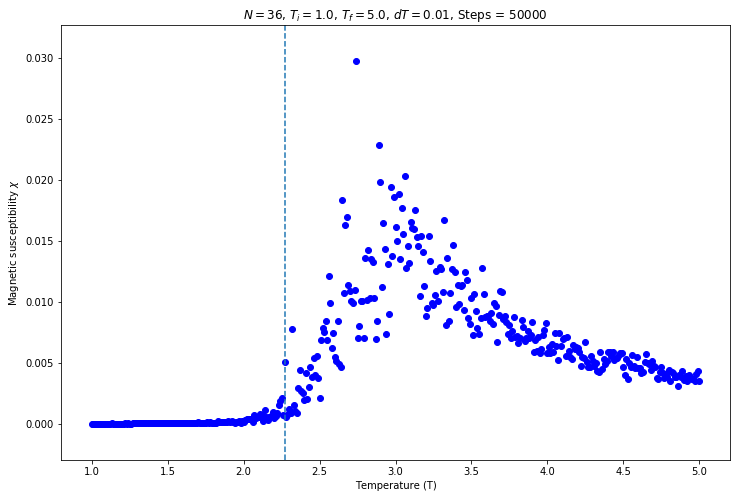

CPU times: user 3min 50s, sys: 984 ms, total: 3min 51s
Wall time: 3min 52s


In [4]:
%%time
## takes around 4 minutes
cyP = cy_Figures(N=36,dt=0.01)
cyP.energy()
cyP.specific_heat()
cyP.mag()
cyP.mag_sus()

## Thermodynamic Quantities at $N=12$.

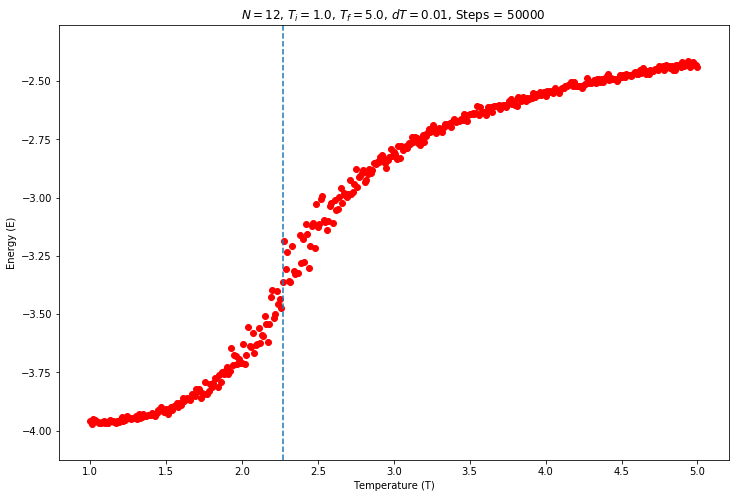

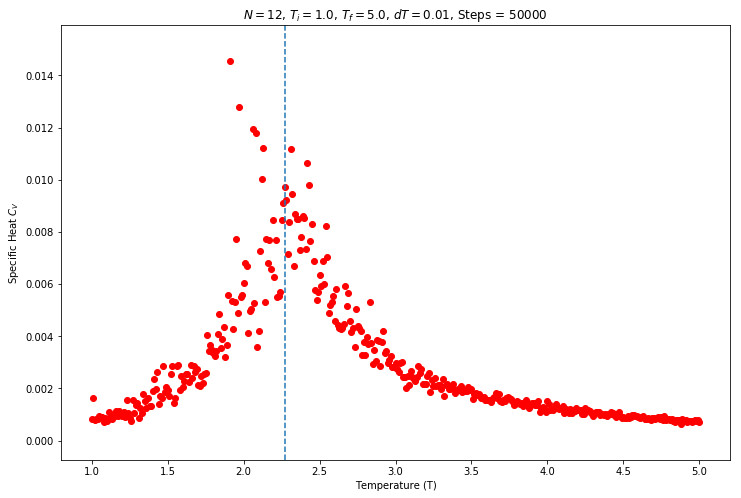

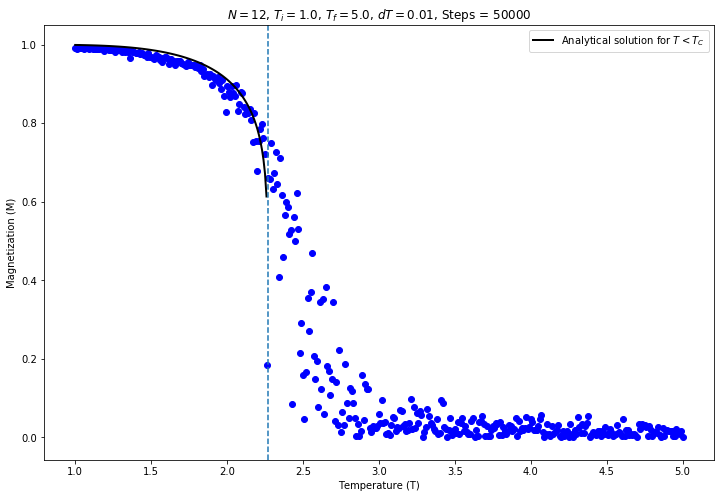

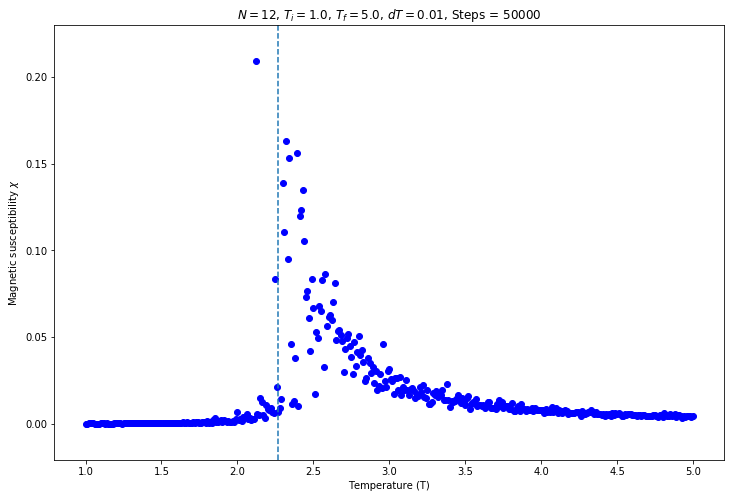

CPU times: user 3min 49s, sys: 1.12 s, total: 3min 50s
Wall time: 3min 56s


In [5]:
%%time
## takes around 4 minutes
cyP = cy_Figures(N=12,dt=0.01)
cyP.energy()
cyP.specific_heat()
cyP.mag()
cyP.mag_sus()